In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(100)
LEVEL = 'level_1'

In [2]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(np.array(list(loss.values())).astype(float))
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [3]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [4]:
languages = ['ta', 'hi', 'en']
#trainPath = "../input/padhai-text-non-text-classification-level-1/"+LEVEL+"_train/"+LEVEL+"/"
#testPath = "../input/padhai-text-non-text-classification-level-1/"+LEVEL+"_test/kaggle_"+LEVEL
images_train = read_all("../input/padhai-text-non-text-classification-level-2/level_2/"+"background", key_prefix='bgr_') # change the path
for language in languages:
  images_train.update(read_all("../input/padhai-text-non-text-classification-level-2/level_2/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all("../input/padhai-text-non-text-classification-level-2/kaggle_level_2", key_prefix='') # change the path
print(len(images_test))

  8%|▊         | 33/407 [00:00<00:01, 328.18it/s]

Reading:


 37%|███▋      | 42/114 [00:00<00:00, 412.14it/s]

Reading:


 30%|███       | 41/136 [00:00<00:00, 407.44it/s]

Reading:


 25%|██▌       | 37/146 [00:00<00:00, 367.83it/s]

Reading:


 13%|█▎        | 39/299 [00:00<00:00, 382.55it/s]

803
Reading:


100%|██████████| 299/299 [00:00<00:00, 386.63it/s]

299


In [5]:
! cd ../input

In [6]:
list(images_test.keys())[:5]

['84', '33', '298', '120', '181']

In [7]:
X_train = []
Y_train = []

for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(803, 256) (803,)
(299, 256)


# MPNeuron

In [8]:
X_train_binarized = []
for i in X_train:
    i = list(i)
    x = [1 if y == 255 else 0 for y in i]
    X_train_binarized.append(np.array(x))

X_test_binarized = []
for i in X_test:
    i = list(i)
    x = [1 if y == 255 else 0 for y in i]
    X_test_binarized.append(np.array(x))

X_train_binarized = np.array(X_train_binarized)
X_test_binarized = np.array(X_test_binarized)

In [9]:
class MPNeuron:
  def __init__(self):
    self.b = None
  
  def model(self,x):
    return 1 if sum(x) >= self.b else 0
  
  def predict(self,X):
    Y = []
    for x in X:
      result = self.model(x)
      Y.append(result)
    return np.array(Y)
  
  def fit(self,X,Y):
    accuracy = {}
    for b in range(X.shape[1]+1):
      self.b = b
      Y_pred = self.predict(X)
      accuracy[b]= accuracy_score(Y_pred,Y)
    best_b = max(accuracy,key=accuracy.get)
    self.b = best_b

In [10]:
mp = MPNeuron()
mp.fit(X_train_binarized, Y_train)
y_pred = mp.predict(X_train_binarized)
print('Accuracy on training data',accuracy_score(y_pred,Y_train))
print(mp.b)

Accuracy on training data 1.0
11


In [11]:
def print_accuracy(sn, binarized = False):
    if binarized:
        Y_pred_train = sn.predict(X_train_binarized)
    else:
        Y_pred_train = sn.predict(X_scaled_train)
    Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
    accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
    print("Train Accuracy : ", accuracy_train)
    print("-"*50)

In [12]:
print_accuracy(mp,binarized=True)

Train Accuracy :  1.0
--------------------------------------------------


# """""""

In [13]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

100%|██████████| 100/100 [00:04<00:00, 21.43epoch/s]


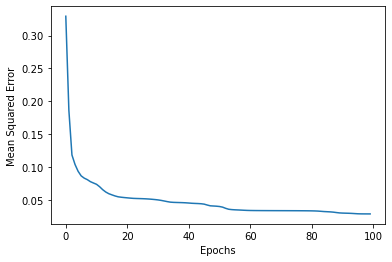

In [14]:
sn_mse = SigmoidNeuron()
sn_mse.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.015, loss_fn="mse", display_loss=True)

100%|██████████| 100/100 [00:03<00:00, 25.61epoch/s]


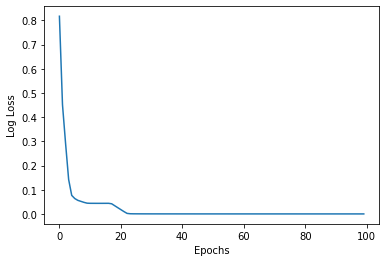

In [15]:
sn_ce = SigmoidNeuron()
sn_ce.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.015, loss_fn="ce", display_loss=True)

In [16]:
def print_accuracy(sn):
  Y_pred_train = sn.predict(X_scaled_train)
  Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
  print("Train Accuracy : ", accuracy_train)
  print("-"*50)

In [17]:
print_accuracy(sn_mse)
print_accuracy(sn_ce)

Train Accuracy :  0.9713574097135741
--------------------------------------------------
Train Accuracy :  1.0
--------------------------------------------------


## Sample Submission

In [18]:
#Y_pred_test = sn_ce.predict(X_scaled_test)
#Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()
Y_pred_binarised_test = mp.predict(X_test_binarized).astype("int").ravel()
submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submission.csv", index=False)

In [19]:
print(submission)

     ImageId  Class
97         0      1
131        1      0
295        2      0
172        3      1
38         4      0
..       ...    ...
139      295      1
272      296      0
87       297      0
2        298      0
96       299      1

[299 rows x 2 columns]


In [20]:
df = submission.copy()
df1 = pd.DataFrame({'ImageId':[240],'Class':[1]})
df2 = pd.concat([df,df1])
df2.to_csv("submission.csv", index=False)